# BTC Price analisys

In this notebook, we will analize the Bitcoin one minute return series. First of all, we will download the dataset from Kaggle (https://www.kaggle.com/mczielinski/bitcoin-historical-data) and try to understand the data it contains.

In [2]:
import pandas as pd

# Read csv and remove rows containing invalid information
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv")
df.dropna(inplace=True)

df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [3]:
# Now we convert timestamp (ms since epoch) to datetime and set it as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.set_index(df['Timestamp'])
df = df.drop(columns=['Timestamp','Volume_(BTC)','Volume_(Currency)','Weighted_Price'])

df.head()

,Open,High,Low,Close
Timestamp,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39
2011-12-31 15:50:00,4.39,4.39,4.39,4.39
2011-12-31 16:59:00,4.50,4.57,4.50,4.57
2011-12-31 17:00:00,4.58,4.58,4.58,4.58
2012-01-01 04:16:00,4.58,4.58,4.58,4.58


## Column analisys

Here we can observe the columns. We have Open, High, Low, Close, Volume (BTC), Volume (Currency) and Weighted price. We will use, for this example, smaller subsets of information filtering it by date.

In this case, we will use the BTC price peak in the end of 2017

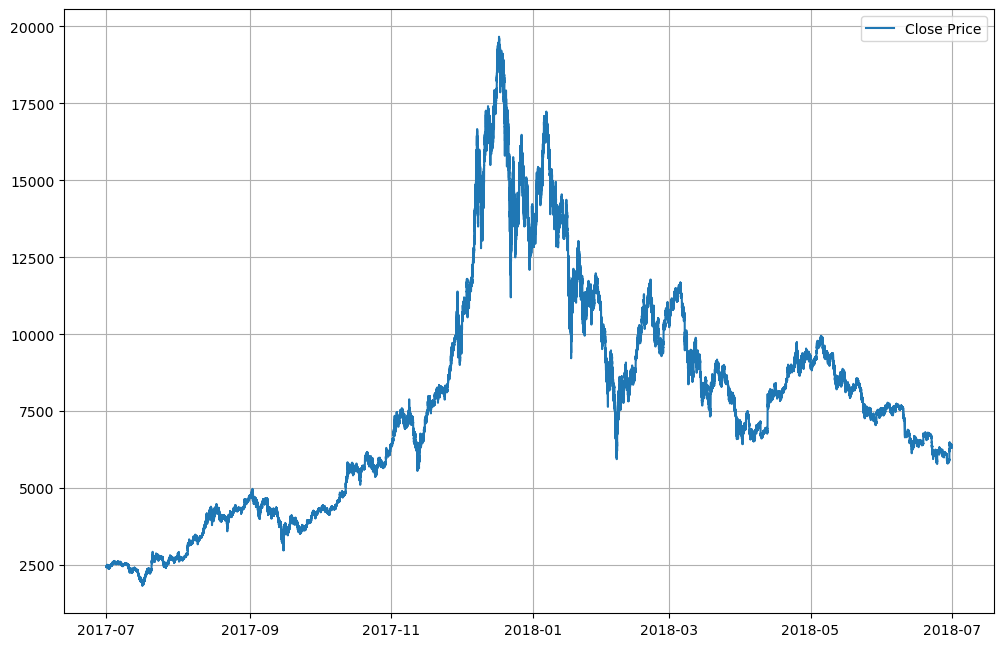

In [4]:

df_1 = df['2017-07-01':'2018-06-30']

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(df_1['Close'],label='Close Price')
plt.grid()
plt.legend()
plt.show()


## Returns
Now let's take a look at the returns of this period. We will plot a returns histogram, and time plot. Since this is a financial asset, it is expected that te mean of the returns is zero. If this doesn't happen, we are looking at an arbitrage opportunity.

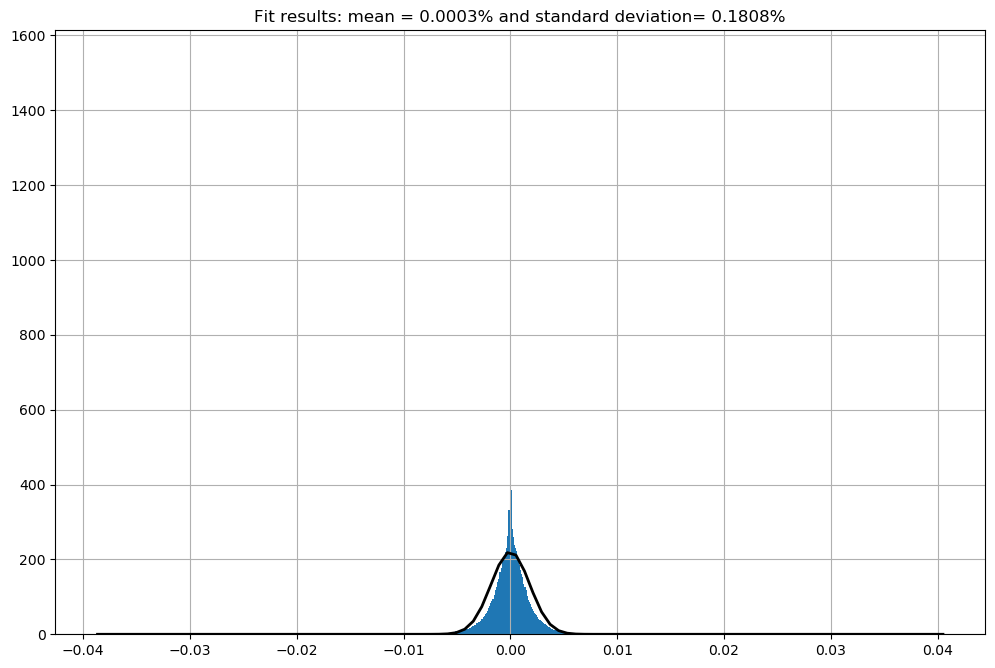

In [5]:
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm
import numpy as np

# Calculate return series
return_series = df_1['Close'].pct_change()
return_series.dropna(inplace=True)

# Create figure
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

bins = int(np.ceil(np.sqrt(len(return_series))))
plt.hist(return_series,bins=bins, density=True)
plt.grid()


# Plot the PDF.
# Fit a normal distribution to the data:
mu, std = norm.fit(return_series)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mean = %.4f%c and standard deviation= %.4f%c" % (100*mu,'%', 100*std,'%')
plt.title(title)
plt.show()

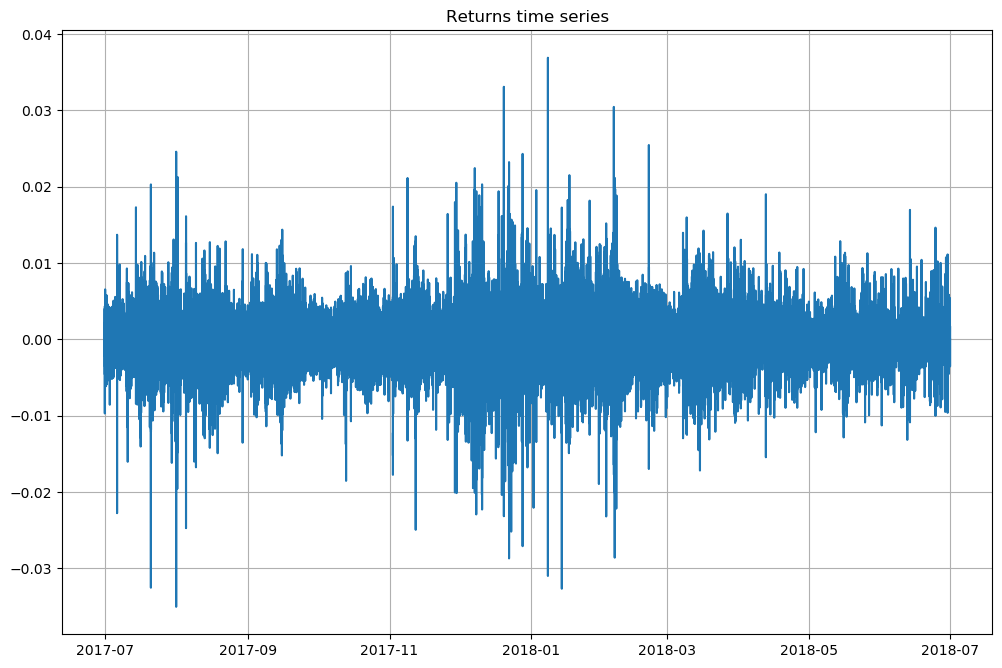

In [6]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.grid()
plt.plot(return_series,label='Returns')
plt.title('Returns time series')
plt.show()

This time series shows no obvious stationarity. Stationarity is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time (https://en.wikipedia.org/wiki/Stationary_process). Nevertheless we should perform some tests to confirm this. 

First of all, let's look at autocorrelation. Autocorrelation is basically comparing a signal (in this case, the returns series) with a delayed version of itself. If the data is non stationary, the autocorrelation should decrease as we increase the lag. On the other hand, if the data is indeed stationary, a more erratic behaviour on the autocorrelation plot is expected.
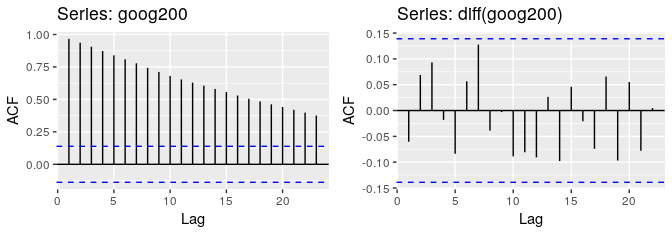
(https://towardsdatascience.com/detecting-stationarity-in-time-series-data-d29e0a21e638)

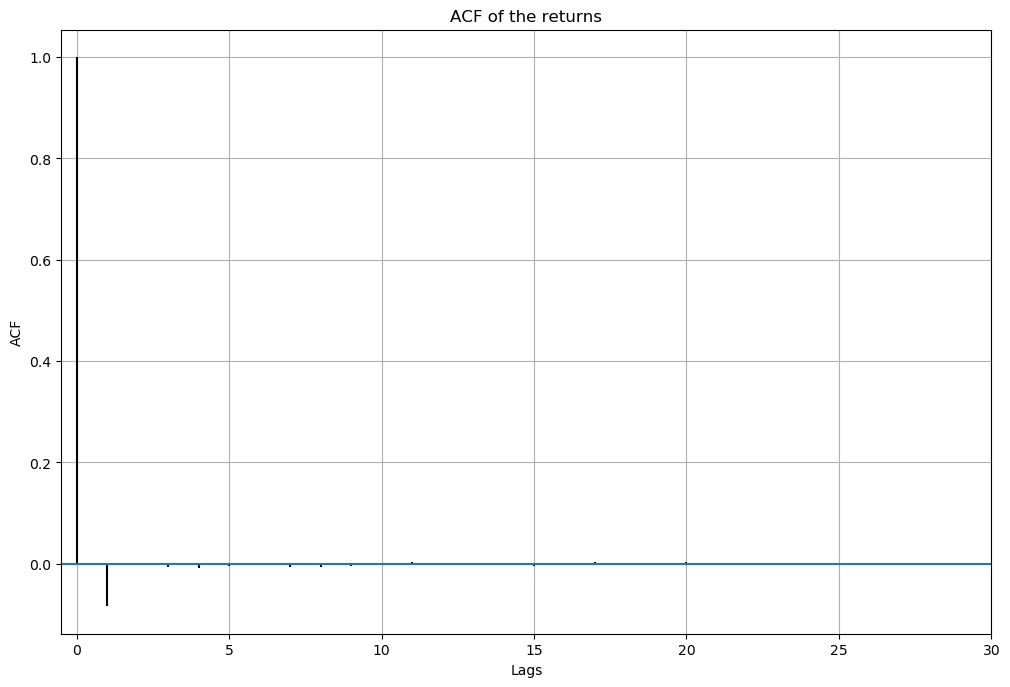

In [7]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.xlabel("Lags")  
plt.ylabel("ACF")
  
# Plotting the Autocorreleation plot. 
plt.acorr(return_series, maxlags = 20)  
  
# Displaying the plot. 
plt.grid(True)
plt.xlim([-0.5,30])
plt.title('ACF of the returns')  
plt.show()

This autocorrelation plot leads to believe, with a greater degree of certainty, that the return series is stationary. 
Now let's check the prices series to check for stationarity.

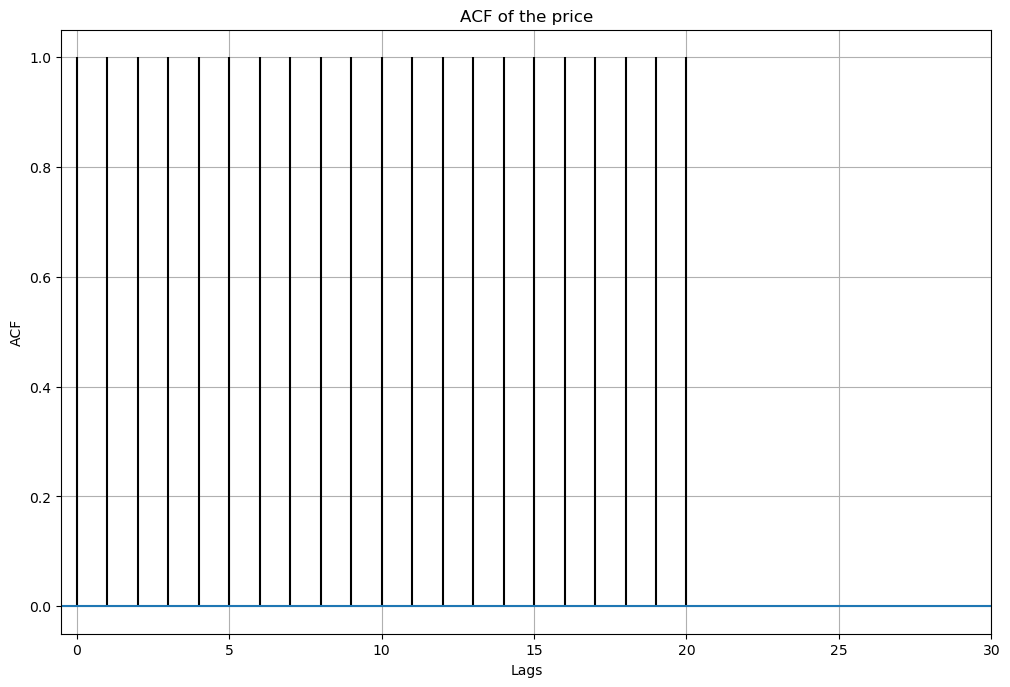

In [8]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.xlabel("Lags")  
plt.ylabel("ACF")
  
# Plotting the Autocorreleation plot. 
plt.acorr(df_1['Close'], maxlags = 20)  
  
# Displaying the plot. 
plt.grid(True)
plt.xlim([-0.5,30])
plt.title('ACF of the price')  
plt.show()

Since the returns are in minutes, it's expected to see a big decline in the ACF as we increase significantly the lag value.

But let's take it a step further. Let's perform a stationarity test. 

## Augmented Dickey-Fuller test

This test is a type of statistical test called a unit root test. The null hypothesis is defined as the presence of a unit root and the alternative hypothesis presents some sort of stationarity (https://en.wikipedia.org/wiki/Unit_root_test). The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [9]:
# https://machinelearningmastery.com/time-series-data-stationary-python/
from statsmodels.tsa.stattools import adfuller

result = adfuller(return_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Statistic: -78.338151
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


Now, with this p-value, we can reject the null hypotesis since 

p-value < 1%

# Strategies: Technical analisys and Machine Learning techniques

In this section, we will evaluate different trading strategies to make performance comparisons of different models. First of all, we will define which strategies we will be using, then we will implement it, and finally we will make the comparison between all the strategies.

## Technical analisys

Technical analysis is a trading discipline employed to evaluate investments and identify trading opportunities by analyzing statistical trends gathered from trading activity, such as price movement and volume. (https://www.investopedia.com/terms/t/technicalanalysis.asp)

We will four three different strategies:
     - MACD
     - Bollinger Bands
     - RSI
     - Long Only
     
     


In [10]:
# Auxiliary functions and imports!
import ta

returns = {}
bp = 0.0025

def calc_one_return(prices, t_start, bp, actions, t1, t2):
    Vi = prices[t_start + t1]; Vf = prices[t_start + t2]
    transaction_cost = abs(actions[t2] - actions[t1])*bp*prices[t_start + t2]
    R = (actions[t1]*(Vf - Vi) - transaction_cost)/Vi
    return R

def make_return_series(prices, bp, t_start, actions):
    num_actions = len(actions)
    R_tot_prev = 0
    R_series = np.empty([num_actions])
    for i in range(num_actions-1):
        R_today = calc_one_return(prices, t_start, bp, actions, i, i+1)
        R_tot_new = (1+R_tot_prev)*(1+R_today) - 1
        R_series[i] = R_tot_new
        R_tot_prev = R_tot_new
    # just to fill missing values
    R_series[-1] = R_series[-2]
    R_series = np.append(R_series,R_series[-1])
    return R_series    

### MACD

Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The result of that calculation is the MACD line. A nine-day EMA of the MACD called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. Traders may buy the security when the MACD crosses above its signal line and sell—or short—the security when the MACD crosses below the signal line. 

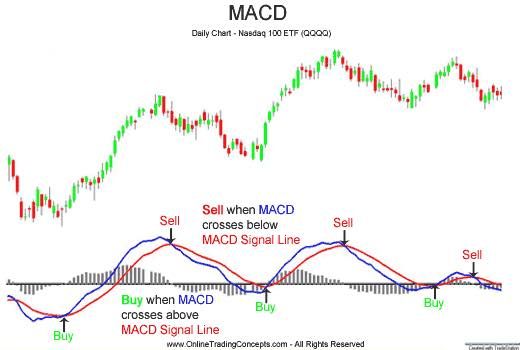

https://www.investopedia.com/terms/m/macd.asp

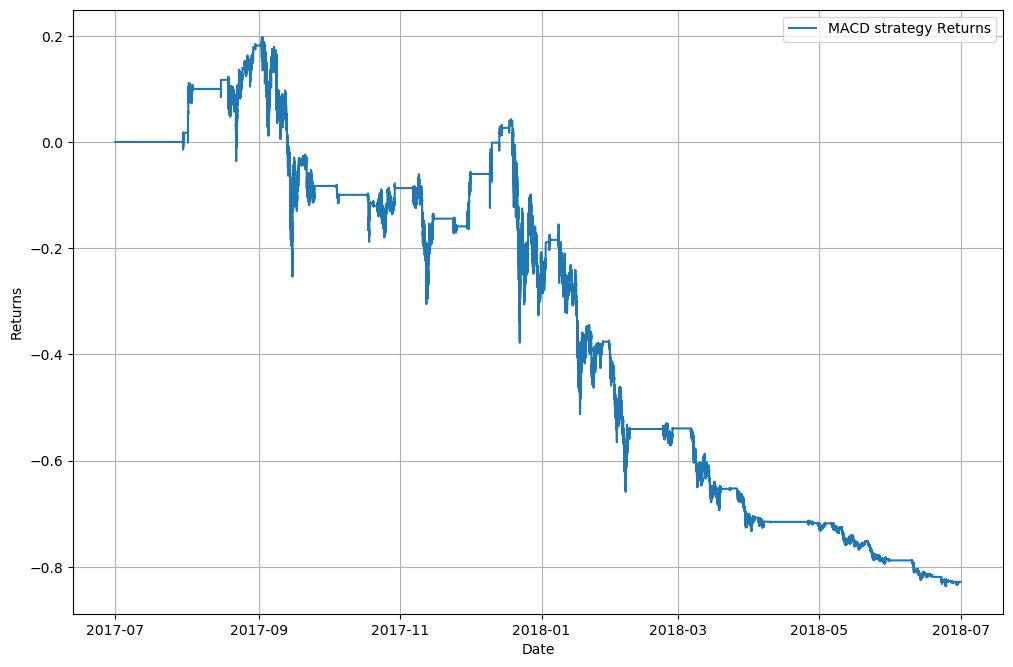

In [11]:
def get_actions_MACD(macd, macd_signal):
    actions = []
    for i in range(len(macd)):
        if i > 0:
            if macd[i] > macd_signal[i]:
                actions.append(1) # compra
            else:
                actions.append(0) # venta
    return actions


prices = df_1['Close'].copy()
prices.dropna(inplace=True)

macd = ta.trend.MACD(close=prices,n_slow = 12 * 60 * 24, n_fast = 26 * 60 * 24)

macd_list = macd.macd()
macd_signal = macd.macd_signal()

dataframe_ta = { 'Prices': prices, 'MACD':macd_list, 'MACD_SIGNAL': macd_signal} 

df_ta = pd.DataFrame(dataframe_ta)
df_ta.fillna(0)

actions = get_actions_MACD(df_ta['MACD'],df_ta['MACD_SIGNAL'])
macd_rets = make_return_series(df_ta['Prices'],bp,1,actions)

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(prices.index.values,macd_rets,label='MACD strategy Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

### Bollinger Bands

A Bollinger Band is a technical analysis tool defined by a set of trendlines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of a security's price, but which can be adjusted to user preferences. 

The first step in calculating Bollinger Bands® is to compute the simple moving average of the security in question, typically using a 20-day SMA. A 20-day moving average would average out the closing prices for the first 20 days as the first data point. The next data point would drop the earliest price, add the price on day 21 and take the average, and so on. Next, the standard deviation of the security's price will be obtained. Standard deviation is a mathematical measurement of average variance and features prominently in statistics, economics, accounting and finance.

For a given data set, the standard deviation measures how spread out numbers are from an average value. Standard deviation can be calculated by taking the square root of the variance, which itself is the average of the squared differences of the mean. Next, multiply that standard deviation value by two and both add and subtract that amount from each point along the SMA. Those produce the upper and lower bands. 

https://www.investopedia.com/terms/b/bollingerbands.asp

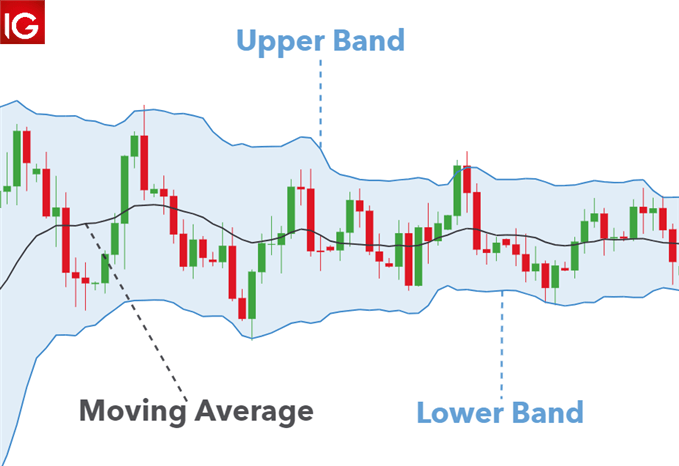

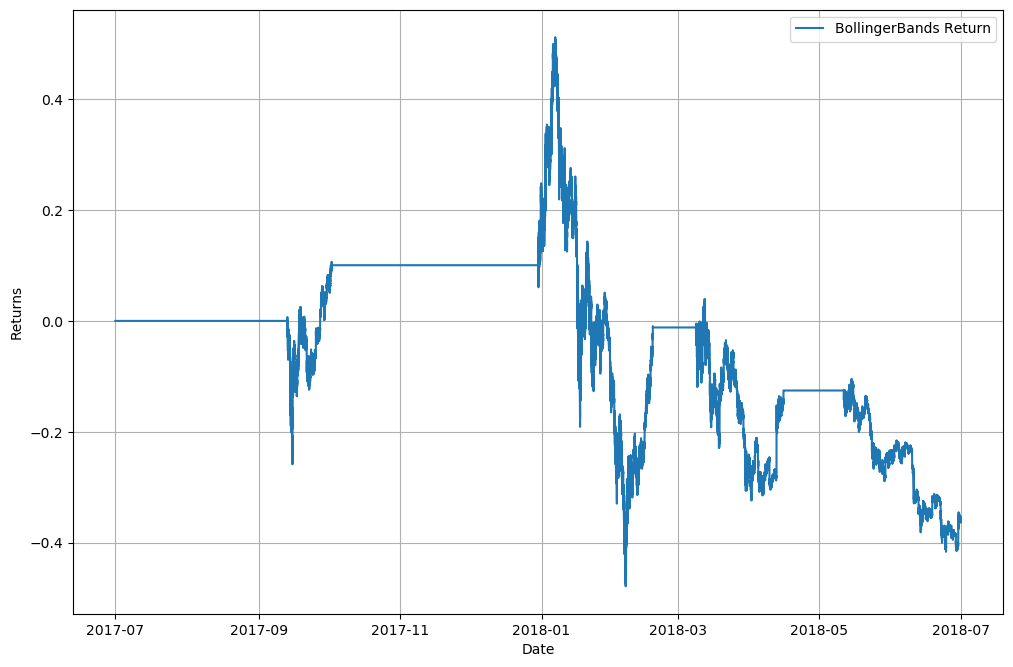

In [12]:
def get_actions_BB(prices,BBUpper,BBLower):
    actions = [0]
    for i in range(len(prices)-1):
        if i > 0:
            if prices[i] < BBLower[i]:
                actions.append(1)
            elif prices[i] > BBUpper[i]:
                actions.append(0)
            else:
                actions.append(actions[-1])           
    return actions


prices = df_1['Close'].copy()
prices.dropna(inplace=True)

BB = ta.volatility.BollingerBands(close=prices,n = 20 * 60 * 24)

BBUpper = BB.bollinger_hband() 
BBLower = BB.bollinger_lband()

actions = get_actions_BB(prices,BBUpper,BBLower)
BB_rets = make_return_series(prices,bp,1,actions)


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(prices.index.values,BB_rets,label='BollingerBands Return')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

### RSI

The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. The indicator was originally developed by J. Welles Wilder Jr. and introduced in his seminal 1978 book, "New Concepts in Technical Trading Systems."

Traditional interpretation and usage of the RSI are that values of 70 or above indicate that a security is becoming overbought or overvalued and may be primed for a trend reversal or corrective pullback in price. An RSI reading of 30 or below indicates an oversold or undervalued condition.

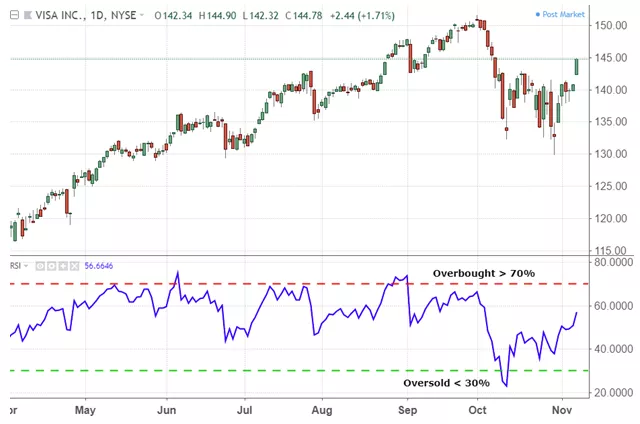

https://www.investopedia.com/terms/r/rsi.asp

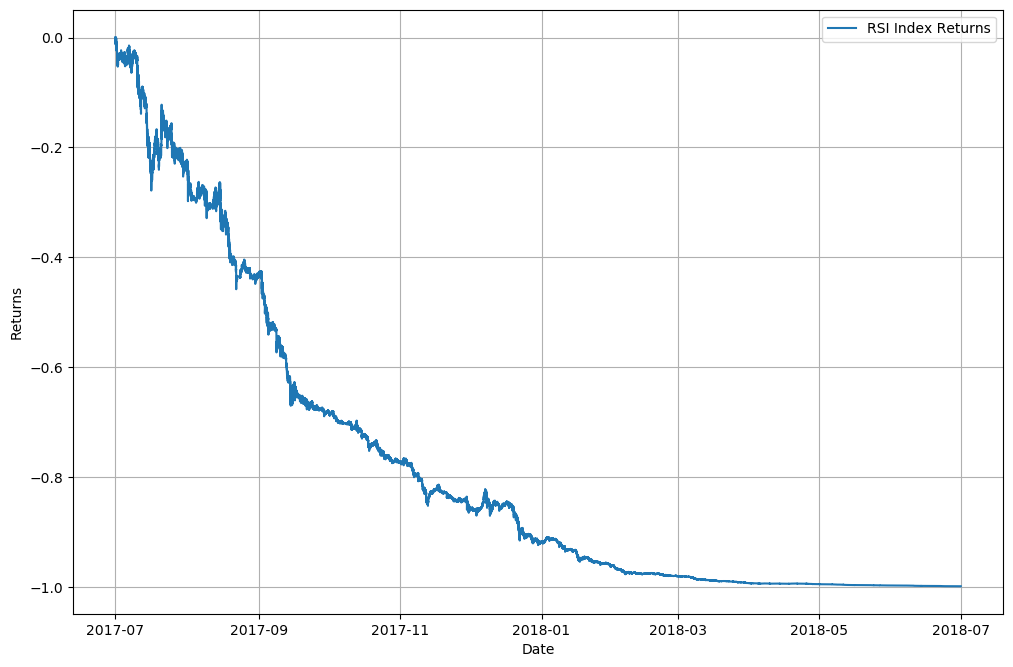

In [13]:
def get_actions_RSI(rsi):
    actions = [0]
    for i in range(len(prices)-1):
        if i > 0:
            if rsi[i] >= 70:
                actions.append(0)
            elif rsi[i] <= 30:
                actions.append(1)
            else:
                actions.append(actions[-1])
    return actions


prices = df_1['Close'].copy()
prices.dropna(inplace=True)

RSI = ta.momentum.RSIIndicator(close=prices,n = 14)

RSIIndicator = RSI.rsi()

actions = get_actions_RSI(RSIIndicator)
RSI_rets = make_return_series(prices,bp,1,actions)


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(prices.index.values,RSI_rets,label='RSI Index Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

### Long Only

This strategy consists only on buying the asset in the beginning and selling it on the end of the time period.

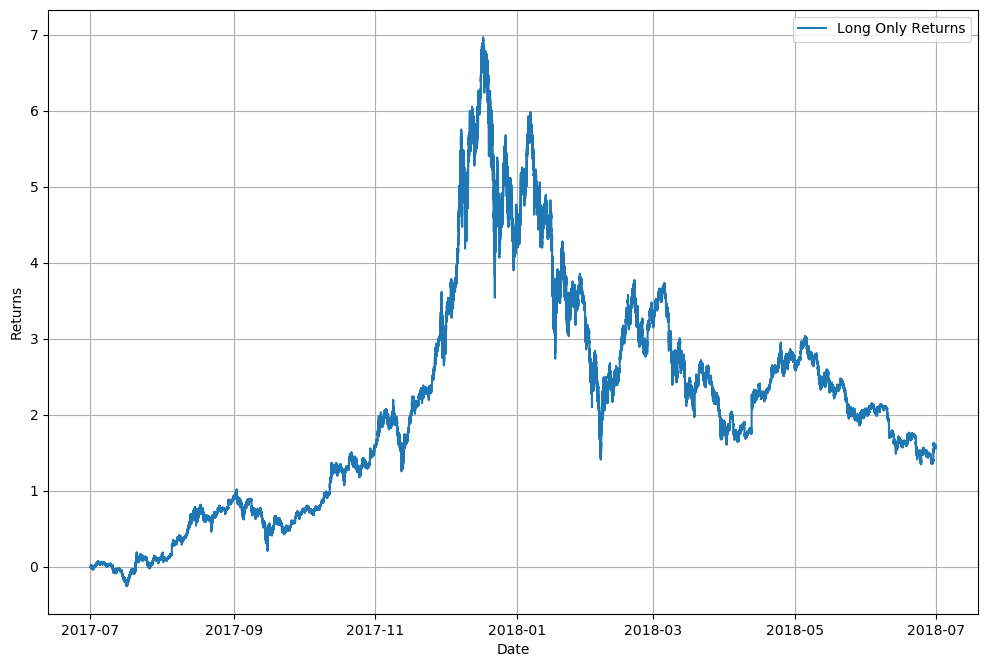

In [14]:
def get_actions_LongOnly(prices):
    actions = []
    for i in range(len(prices)):
        if i > 0:
            actions.append(1)
    return actions


prices = df_1['Close'].copy()
prices.dropna(inplace=True)

actions = get_actions_LongOnly(prices)
long_only_rets = make_return_series(prices,bp,1,actions)


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(prices.index.values,long_only_rets,label='Long Only Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

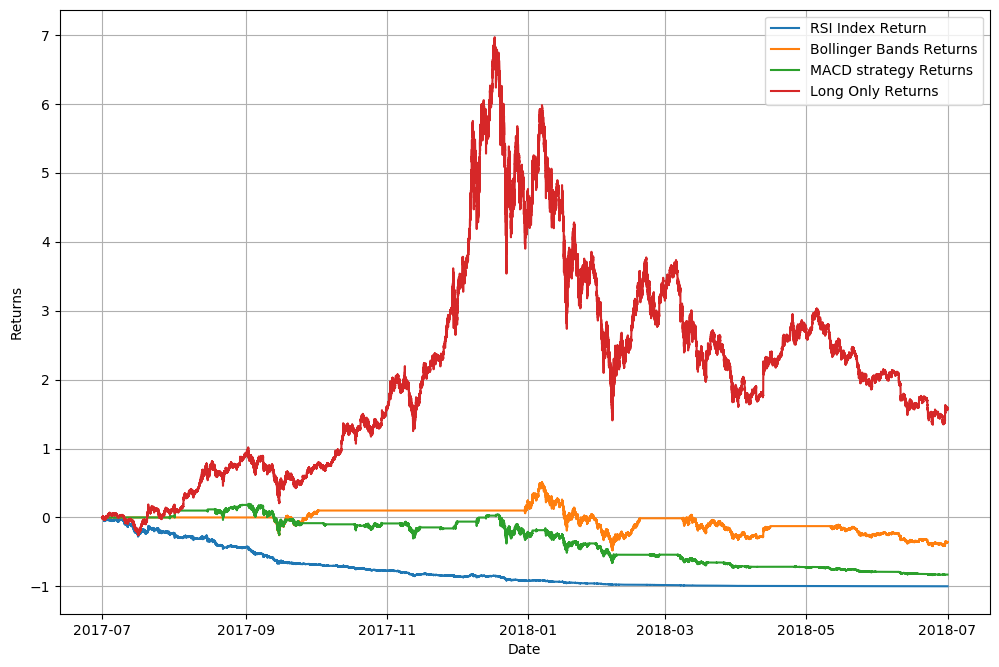

In [15]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(prices.index.values,RSI_rets,label='RSI Index Return')
plt.plot(prices.index.values,BB_rets,label='Bollinger Bands Returns')
plt.plot(prices.index.values,macd_rets,label='MACD strategy Returns')
plt.plot(prices.index.values,long_only_rets,label='Long Only Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

### Conclusions

Looking at the returns series, it would appear that the most profitable strategy (by far) is the Buy and Hold strategy. Let's see if by using some other type of strategies we could improve (or at least try to reach) this level of performance.

## Machine Learning

Machine Learning is a vast field, depending on the problem you are facing. It's basically a form of "teaching" the software to make predictions, clasifications, or take actions based on previous information. There are two tipes of machine learning algorithms: supervised learning (where you provide the input information and the expected output) and unsupervised learning (in which you teach the algorithm only with unlabeled data).

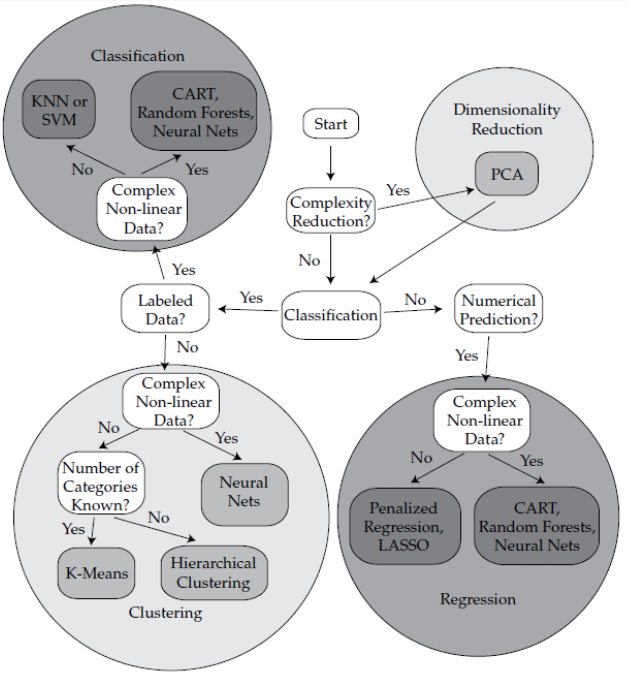

In this trading example, we will try different models in order to try to "predict" the price, so that we could act based on this prediction. Acording to the image presented before, we will try algorithms that fit in the regression group. After training this algorithms, we will discuss trading strategies arround this predictions.

### Lasso Regression

Lasso regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. The lasso procedure encourages simple, sparse models (i.e. models with fewer parameters).

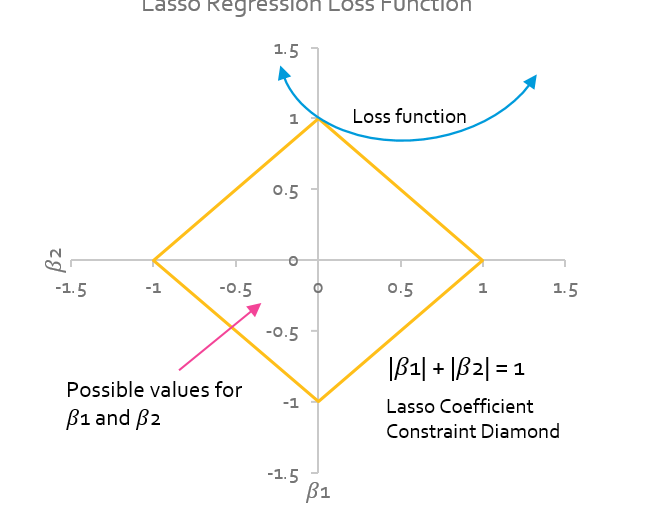

(https://www.statisticshowto.com/lasso-regression/)

We will try a model similar to the model implemented in https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwj6xa376dXsAhX7HLkGHesZBdEQFjABegQIChAC&url=https%3A%2F%2Fwww.researchgate.net%2Fpublication%2F278660757_Stock_Market_Forecasting_Using_LASSO_Linear_Regression_Model&usg=AOvVaw0u7w9x522RwHre8OOy3OD8.


In [16]:
import sklearn.linear_model as sk_lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Now let's define our output. We would like to predict, based on the OHLV information
# if the next price will be higher or lower. If we have this prediction, we could buy or sell
# depending on the value!

df_lasso = df.copy()
# We create our target column named "'Price_shifted'"
df_lasso['Price_shifted'] = df_lasso['Close'].shift(-1)
df_lasso.dropna(inplace=True)


# Split df to keep test data out of sample 

X_tr = df_lasso[:'2017-06-30']
y_tr = X_tr['Price_shifted']
X_tr.drop(columns=['Price_shifted'],inplace=True)

X_te = df_lasso['2017-07-01':'2018-06-30']
y_te = X_te['Price_shifted']
X_te.drop(columns=['Price_shifted'],inplace=True)

regression = sk_lm.LassoCV(cv=5).fit(X_tr, y_tr)

# Now let's check the score in the training set
y_pred = regression.predict(X_tr)
R2 = r2_score(y_tr,y_pred)
print("R2 of train set: " + str(100*R2) + "%")

# Now let's do the same with the test set.
y_pred = regression.predict(X_te)
R2 = r2_score(y_te,y_pred)
print("R2 of test set: " + str(100*R2) + "%")

R2 of train set: 99.99831393862098%
R2 of test set: 99.99544147814372%


Lasso regression appears to have a great prediction power for the prices on this data set. Let's see if we can use this prediction for trading.

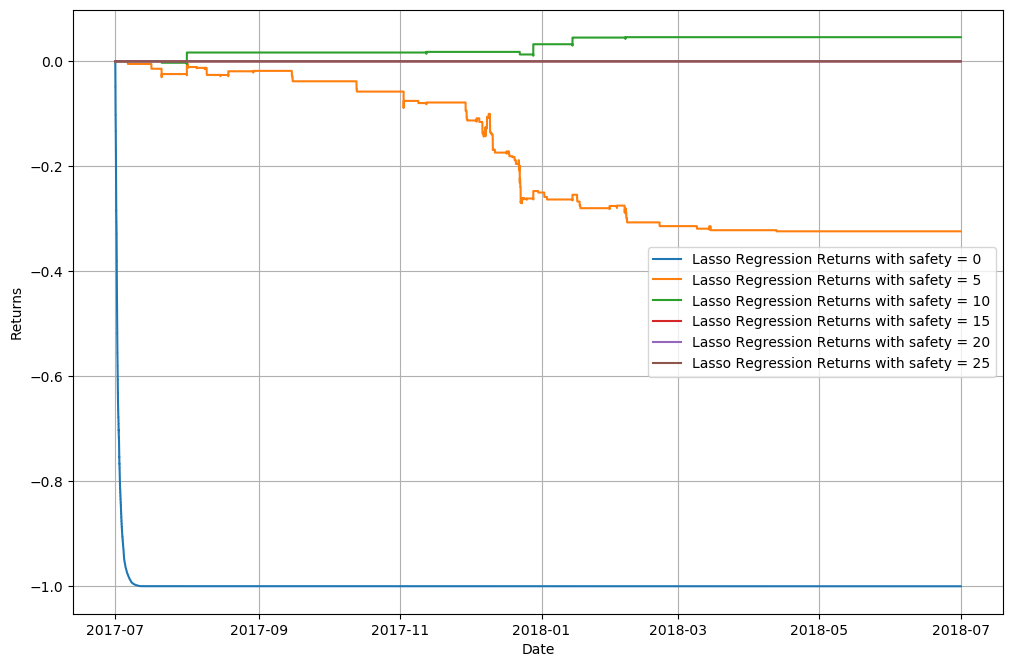

In [17]:
def get_actions_lasso(prices,predictions, safety):
    actions = []
    for i in range(len(prices)):
        if i > 0:
            if predictions[i] > (prices[i] * (1+ safety *bp)):
                actions.append(1)
            else:
                actions.append(0)
    return actions


y_pred = regression.predict(X_te)

prices = X_te['Close']

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

lasso_rets_arr = []
lasso_rets = []
max_ret = 0
for i in range(0,30,5):
    actions = get_actions_lasso(prices,y_pred,i)
    lasso_rets_arr = make_return_series(prices,bp,1,actions)
    if lasso_rets_arr[-1] > max_ret:
        max_ret = lasso_rets_arr[-1]
        lasso_rets = lasso_rets_arr
    plt.plot(prices.index.values,lasso_rets_arr,label='Lasso Regression Returns with safety = '+str(i))    

plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

This is actually a very interesting (yet, obvious) result. The more "sure" the algorithm has to be in order to buy, the better it actually does. Nevertheless, taking trading commissions into account, only the "safest" strategy had possitive return in the end. This strategies usually make a lot of trades (since the information is also in minutes). The returns calculation takes this into account and "penalizes" this.

Lets take a similar approach and make this calculations with a more complex non-linear algorithm.

### Random Forest

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

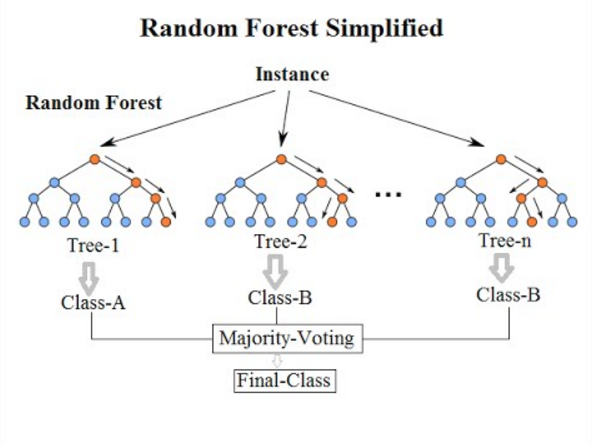

(https://en.wikipedia.org/wiki/Random_forest)

In [18]:
import sklearn.ensemble as sk_ens
from sklearn.metrics import mean_squared_error, r2_score

# Now let's define our output. We would like to predict, based on the OHLV information
# if the next price will be higher or lower. If we have this prediction, we could buy or sell
# depending on the value!

df_rf = df.copy()
# We create our target column named "'Price_shifted'"
df_rf['Price_shifted'] = df_rf['Close'].shift(-1)
df_rf.dropna(inplace=True)


# Split df to keep test data out of sample 

X_tr = df_rf[:'2017-06-30']
y_tr = X_tr['Price_shifted']
X_tr.drop(columns=['Price_shifted'],inplace=True)

X_te = df_rf['2017-07-01':'2018-06-30']
y_te = X_te['Price_shifted']
X_te.drop(columns=['Price_shifted'],inplace=True)

regression = sk_ens.RandomForestRegressor(n_estimators=100).fit(X_tr, y_tr)

# Now let's check the score in the training set
y_pred = regression.predict(X_tr)
R2 = r2_score(y_tr,y_pred)
print("R2 of train set: " + str(100*R2) + "%")

# Now let's do the same with the test set.
y_pred = regression.predict(X_te)
R2 = r2_score(y_te,y_pred)
print("R2 of test set: " + str(100*R2) + "%")

R2 of train set: 99.99975953567257%
R2 of test set: -169.47219675748272%


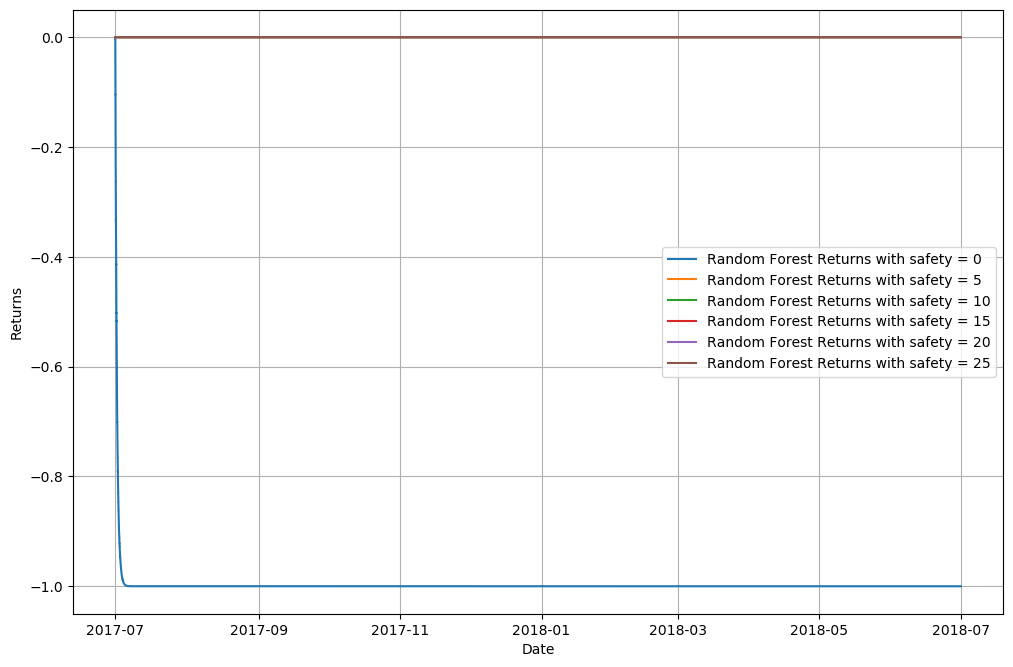

In [19]:
def get_actions_RF(prices,predictions, safety):
    actions = []
    for i in range(len(prices)):
        if i > 0:
            if predictions[i] > (prices[i] * (1+ safety *bp)):
                actions.append(1)
            else:
                actions.append(0)
    return actions


y_pred = regression.predict(X_te)

prices = X_te['Close']

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

RF_rets_arr = []
RF_rets = []
max_ret = -1
for i in range(0,30,5):
    actions = get_actions_RF(prices,y_pred,i)
    RF_rets_arr = make_return_series(prices,bp,1,actions)
    if RF_rets_arr[-1] > max_ret:
        max_ret = RF_rets_arr[-1]
        RF_rets = RF_rets_arr
    plt.plot(prices.index.values,RF_rets_arr,label='Random Forest Returns with safety = '+str(i))    

plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

This algorithm performs worse than Lasso. Probably trees, given the limited amount of very similar inputs, are not a good algorithm to try in this case.

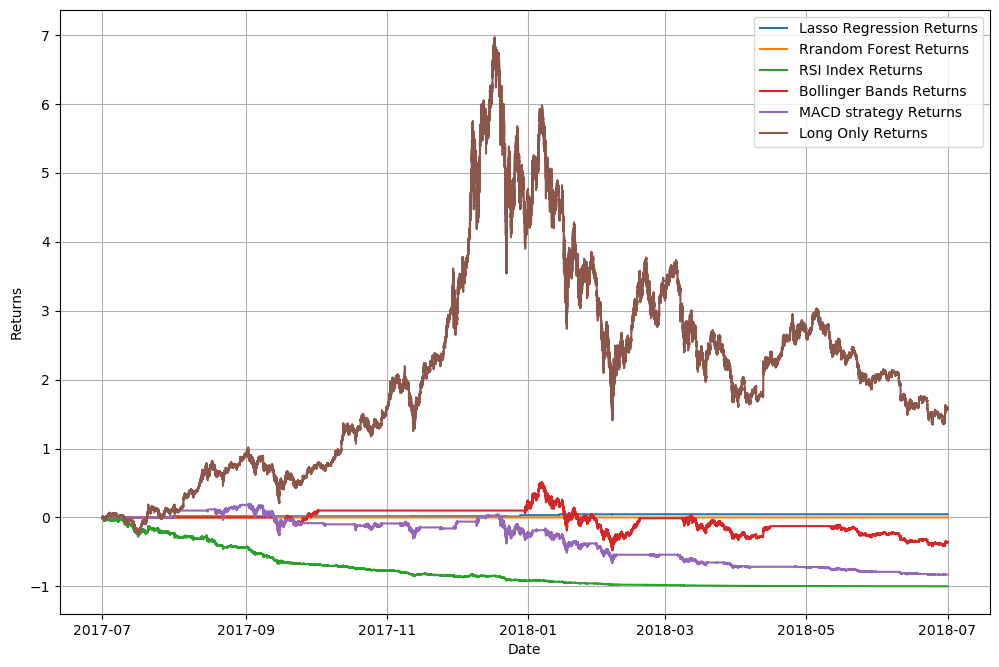

In [20]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(prices.index.values,lasso_rets,label='Lasso Regression Returns')
plt.plot(prices.index.values,RF_rets,label='Rrandom Forest Returns')
plt.plot(prices.index.values,RSI_rets,label='RSI Index Returns')
plt.plot(prices.index.values,BB_rets,label='Bollinger Bands Returns')
plt.plot(prices.index.values,macd_rets,label='MACD strategy Returns')
plt.plot(prices.index.values,long_only_rets,label='Long Only Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

We can conclude that if we include transaction costs in our analysis, the most profitable stategy would have been to just buy and hold the asset.